In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time # pour comparer les algorithmes en fonction de leur durée d'éxecution

- Batch Proximal Gradient Descent (avec accéleration Nesterov, aka FISTA)
- SDCA
- SVRG
- SAGA

# SDCA sur SVM avec régularisation LASSO

Nous allons en premier lieu nous concentrer sur l'algorithme SVM avec régularisation LASSO. 

Commençons par définir les notations afin de fixer les idées :
- les données seront notées par la matrice $X$ de taille (n_samples, n_features)
- le paramètre à estimer est $\theta$ de taille n_features
- les valeurs à prédire sont dans le vecteur $b$ de taille n_samples

Afin de pouvoir fixer de manière optimale les pas de descente, nous allons utiliser une version smooth de la hinge loss : la square hinge loss (smoothness $\gamma = \| X \|_2$), mais qui n'est pas strongly convex. On s'attend donc à avoir une convergence en $\frac{\gamma}{t} $.

$$ l(b,X^T \theta) = \frac{1}{n\_samples} \sum_{i=1}^{n\_samples} max(0, 1 - b_i X_i^T \theta)^2 $$

Le gradient s'écrit

$$ \nabla_\theta l(b, X^T \theta) = \frac{1}{n\_samples}  \sum_{i=1}^{n\_samples} \left\{
    \begin{array}{ll}
        0 & \mbox{si } b_i X_i^T \theta > 1 \\
        -2 b_i X_i^T (1 - b_i X_i^T \theta) & \mbox{sinon.}
    \end{array}
\right. $$

Enfin, la perte considéré étant le LASSO, ie la régularisation l1, le fontion $\psi$ considérée s'écrit ici :
$$ \psi (\theta) = \lambda |\theta|_1 $$ 

Le prox se calcule donc de cette manière :

$$ \theta_{t+1} = \theta_t - \eta \nabla_\theta l(b, X^T \theta_t) - \eta \lambda \text{sgn}(\theta_t) $$
(en principe il faudrait utiliser sgn($\theta$) mais nous ferons une approximation...)

Enfin, au cours de ce notebook, nous ne lancerons pas les différents algorithmes sur un nombre d'itérations fixé à l'avance, mais sur un budget 'temps' fixé à l'avance (par exemple on donnera 5 secondes à tous les algorithmes).

*[Partie 0 : Définition des données](#section0)

*[Partie 1 : Batch Proximal Gradient Descent](#section1)

*[Partie 2 : FISTA](#section2)

*[Partie 3 : SVRG](#section3)

*[Partie 4 : SAGA](#section4)

*[Partie 5 : Primal Coordinate descent](#section5)

*[Partie 6 : SDCA](#section6)

*[Partie 7 : Comparaison](#section7)

<a id='section0'></a>

# Définition des données

Commençons par définir les données de test qui seront plus tard remplacées par les vraies données.

In [3]:
np.random.seed(0)

def binarize(x):
    return np.sign(x)

n_samples, n_features = 2000, 40
X = np.random.randn(n_samples, n_features)
w = np.random.randn(n_features)
b = binarize(X.dot(w) + 0.1 * np.random.randn(n_samples))

Nous utiliserons par la suite le dataset Titanic. L'idée est qu'à partir des caractéristiques d'un passager, on cherche à prédire si celui-ci survit ou pas. 

Afin de tester l'algorithme dans plusieurs conditions, on va s'autoriser à dupliquer les données en lignes ou en colonnes (on rajoute des passagers fictifs ou des variables supplémentaires). Ainsi, on ne change pas la 'difficulté intrinsèque' du problème (l'optimum ne bouge pas !) mais on va pouvoir observer comment se comportent les algorithmes lorsqu'on scale. Voici les 4 cas considérés :
- n_samples petit, n_features petit (c'est le cas de base : 1045 individus, 6 dimensions)
- n_samples grand, n_features petit (on fait n_samples * 100)
- n_samples petit, n_features grand (on fait n_features * 100)
- n_samples grand, n_features grand (on fait n_samples \* 100, n_features * 100)

In [4]:
import pandas as pd
# on importe la bdd initiale
data = pd.read_excel('titanic3.xls')

data = data[['pclass','sex','age','sibsp','parch','fare','survived']]
data = data.dropna()
X = data[['pclass','sex','age','sibsp','parch','fare']]
X = pd.get_dummies(X)
X = X[['pclass','sex_female','age','sibsp','parch','fare']]
b=data.survived

X = X.values
b = b.values

In [5]:
# on scale les données
def grand_petit(X,b):    
    X = np.concatenate([X for i in range(100)], axis=0)
    b = np.concatenate([b for i in range(100)], axis=0)
    return X,b
    
def petit_grand(X,b):
    X = np.concatenate([X for i in range(100)], axis=1)
    return X,b
    
def grand_grand(X,b):
    X,b = petit_grand(X,b)
    X,b = grand_petit(X,b)
    return X,b
 
# Ici il faut choisir dans quel cas on se met, on laisse tout en commentaire si on veut rester dans le cas de base 'petit_petit'
#X,b = grand_petit(X,b)
X,b = petit_grand(X,b)
#X,b = grand_grand(X,b)

In [6]:
X.shape

(1045, 600)

In [7]:
n_samples, n_features = X.shape

import sklearn.preprocessing
X = sklearn.preprocessing.normalize(X)

On définit aussi les fonctions de couts et les gradients (partiels ou non) pour la fonction hinge et la squared hinge

In [8]:
# On commence avec la hinge normale
def f_hinge(theta, lam):
    cost = 1-np.multiply(b,X.dot(theta))
    cost[cost <= 0] = 0
    return np.mean(cost) + lam * np.linalg.norm(theta, ord=1)

def partial_grad_hinge(theta, i):
    if b[i] * X[i].dot(theta) < 1:
        return -b[i] * X[i]
    return 0 * X[i] 

def grad_hinge(theta):
    gradient = -np.multiply(b, X.T)
    gradient[:,np.multiply(b, X.dot(theta)) >= 1] = 0 * gradient[:,np.multiply(b, X.dot(theta)) >= 1]
    return np.mean(gradient, axis=1)


# On continue avec la squared hinge
def f(theta, lam):
    cost = (1-np.multiply(b,X.dot(theta))) ** 2
    cost[cost <= 0] = 0
    return np.mean(cost) + lam * np.linalg.norm(theta, ord=1)

def partial_grad(theta, i):
    if b[i] * X[i].dot(theta) < 1:
        return -2 * b[i] * X[i]* (1 - b[i] * X[i].dot(theta))
    return 0 * X[i] 

def partial_coordinate_grad(theta, i):
    gradient = np.multiply( np.multiply(-2*b, X[:,i].T) , (1 - np.multiply(b, X[:,i]*theta[i])) )
    gradient[np.multiply(b, X[:,i]*theta[i]) >= 1] = 0 * gradient[np.multiply(b, X[:,i]*theta[i]) >= 1]  
    return np.mean(gradient)

def grad(theta):
    gradient = np.multiply( np.multiply(-2*b, X.T) , (1 - np.multiply(b, X.dot(theta))) )
    gradient[:,np.multiply(b, X.dot(theta)) >= 1] = 0 * gradient[:,np.multiply(b, X.dot(theta)) >= 1]   
    return np.mean(gradient, axis=1)

et les différentes constantes :
- pénalisation : lambda = $\frac{1}{\text(n\_features)}$
- pas de descente : eta = $\frac{1}{\|X\|_2}$  ($\frac{1}{\gamma}$, avec $\gamma=\|X\|_2$)
- nombre d'itérations : T = 300

In [9]:
lam = 1./n_features
eta = 1./(np.linalg.norm(X))
T = 300

<a id='section1'></a>

# Batch Proximal Gradient Descent

Commençons avec l'algorithme le plus simple : la descente de gradient proximale. 

In [10]:
def PGD(T, lam, eta):
    # on déclenche le timer
    t0 = time.time()
    
    # initialisation
    theta = np.zeros(n_features)
    
    # historique des fonctions de perte
    cost_history = np.empty(shape=[T])
    time_history = np.empty(shape=[T,2])
    
    for t in range(0,T):
        cost_history[t] = f(theta, lam)
        time_history[t] = (time.time()-t0, f(theta, lam))
        
        # compute gradient
        gt = grad(theta)
        
        # compute prox
        theta = theta - eta * gt - eta * lam * np.sign(theta)
               
    return theta, cost_history, time_history

In [11]:
theta, cost_history_PGD, time_history_PGD = PGD(T=T,lam=lam,eta=eta)

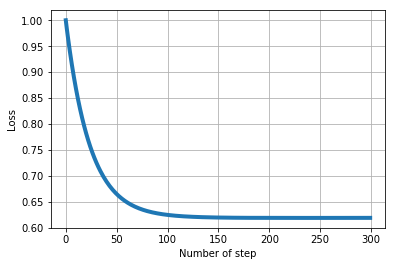

In [12]:
plt.plot(cost_history_PGD, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

<a id='section2'></a>

# FISTA

Une accélération est proposée dans le cours, implémentons-la aussi : c'est l'accélération Nesterov.

In [16]:
def FISTA(T, lam, eta):
    # on déclenche le timer
    t0 = time.time()
    
    # initialisation des s
    st_moins2 = 1.
    st_moins1 = 1.
    st = 1.
    
    # initialisation
    xt = np.zeros(n_features)
    xt_moins1 = np.zeros(n_features)
    yt = np.zeros(n_features)
    
    # historique des fonctions de perte
    cost_history = np.empty(shape=[T])
    time_history = np.empty(shape=[T,2])
    
    for t in range(0,T):
        cost_history[t] = f(xt, lam)
        time_history[t] = (time.time()-t0, f(xt, lam))
        
        # compute gradient
        gt = grad(xt)
        
        # compute prox
        xt_moins1 = xt
        xt = yt - eta * gt - eta * lam * np.sign(yt)   
        
        # compute st
        st_moins2 = st_moins1
        st_moins1 = st
        st = (1 + np.sqrt(1 + 4 * st_moins1**2)) / 2 
        
        # compute nestorov acceleration
        yt = xt + (st_moins2 / st) * (xt - xt_moins1)  
               
    return xt, cost_history, time_history

In [17]:
theta, cost_history_FISTA, time_history_FISTA = FISTA(T=T,lam=lam,eta=eta)

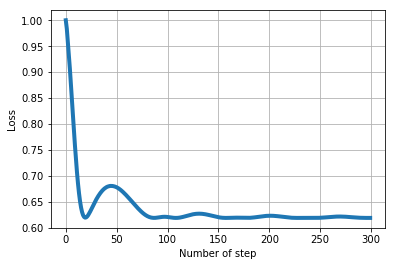

In [18]:
plt.plot(cost_history_FISTA, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

<a id='section3'></a>

# SVRG 

L'algorithme SVRG est aussi proposé dans le cours comme une accélération de la descente de gradient. Implémentons-le :

In [19]:
def SVRG(T, m, lam, eta):
    # on déclenche le timer
    t0 = time.time()
    
    # initialisation
    theta_hat = np.zeros(n_features)
    
    # historique des fonctions de perte
    cost_history = np.empty(shape=[T])
    time_history = np.empty(shape=[T,2])
    
    for t in range(0,T): 
        cost_history[t] = f(theta_hat, lam)
        time_history[t] = (time.time()-t0, f(theta_hat, lam))
        
        # vrai gradient
        g_hat = grad(theta_hat)
    
        theta = np.zeros([m+1, n_features])
        theta[0,:] = theta_hat
        for k in range(0,m):
            # random sample an indice
            idx = np.random.randint(0, n_samples) 

            # compute variance reduced gradient
            g = partial_grad(theta[k], idx) - partial_grad(theta_hat, idx) + g_hat

            # compute prox
            theta[k+1] = theta[k] - eta * g - eta * lam * np.sign(theta[k])
        
        # on retire la première ligne
        theta = theta[1:]
        
        theta_hat = np.mean(theta, axis=0)
        
    return theta_hat, cost_history, time_history

In [20]:
theta, cost_history_SVRG, time_history_SVRG = SVRG(T=T, m=20, lam=lam, eta=eta)

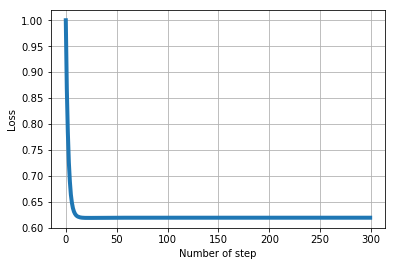

In [21]:
plt.plot(cost_history_SVRG, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

<a id='section4'></a>

# SAGA

Pour terminer, SAGA est aussi proposé comme une accélération, le voici :

In [22]:
def SAGA(T, lam, eta):
    # on déclenche le timer
    t0 = time.time()
    
    # initialisation
    theta = np.zeros(n_features)
    
    gi_hat = np.zeros([n_samples, n_features])
    g_bar = np.zeros(n_features)
    
    # historique des fonctions de perte
    cost_history = np.empty(shape=[T])
    time_history = np.empty(shape=[T,2])
    
    for t in range(0,T): 
        cost_history[t] = f(theta, lam)
        time_history[t] = (time.time()-t0, f(theta, lam))
        
        # random sample an indice
        idx = np.random.randint(0, n_samples) 
        
        # compute partial gradient
        gi = partial_grad(theta, idx)
        
        # estimate gradient
        g_hat = gi - gi_hat[idx] + g_bar
        
        # update average gradient
        g_bar = g_bar + (1./n_samples) * (gi - gi_hat[idx])
        
        # update stored gradient
        gi_hat[idx] = gi
        
        # compute prox
        theta = theta - eta * g_hat - eta * lam * np.sign(theta)
                          
    return theta, cost_history, time_history

In [23]:
theta, cost_history_SAGA, time_history_SAGA = SAGA(T=T, lam=lam, eta=eta)

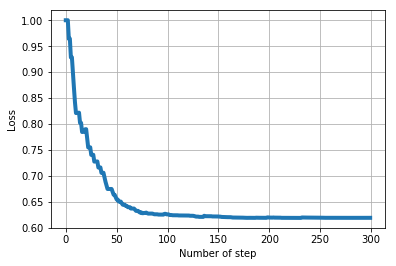

In [24]:
plt.plot(cost_history_SAGA, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

<a id='section5'></a>

# Primal Coordinate Descent

Nous allons commencer avec l'algorithme de coordinate descent dans le cadre primal avant de passer au problème dual (ie. l'algo SDCA)

In [25]:
def CD(T, lam, eta):
    # on déclenche le timer
    t0 = time.time()
    
    # initialisation
    theta = np.zeros(n_features)
    
    # historique des fonctions de perte
    cost_history = np.empty(shape=[T])
    time_history = np.empty(shape=[T,2])
    
    for t in range(0,T):
        cost_history[t] = f(theta, lam)
        time_history[t] = (time.time()-t0, f(theta, lam))
        
        # .. pick random coordinate ..
        idx = np.random.randint(0, n_features)
        
        # compute partial gradient
        gj = partial_coordinate_grad(theta, idx)
        
        # compute prox
        theta[idx] = theta[idx] - eta * gj - eta * lam * np.sign(theta[idx])
               
    return theta, cost_history, time_history

In [26]:
theta, cost_history_CD, time_history_CD = CD(T=T,lam=lam,eta=eta)

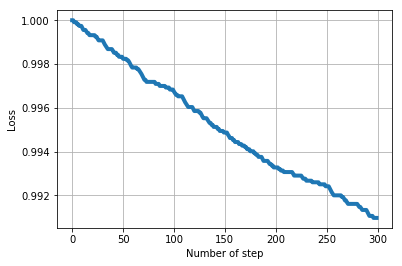

In [27]:
plt.plot(cost_history_CD, lw=4)
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

<a id='section6'></a>

# SDCA

Nous allons maintenant implémenter la version la plus classique de l'algorithme (http://www.jmlr.org/papers/volume14/shalev-shwartz13a/shalev-shwartz13a.pdf).

Nous définissons les fonctions de coût (primal et dual) qui permettront de monitorer l'avancée de l'algorithme. 
Remarque : la fonction P est identique à la fonction f_hinge définie plus haut, mais nous avons décidé de la redéfinir ici pour faire correspondre les notations aux notations de l'article.

In [28]:
def P(theta, lam):
    cost = 1-np.multiply(b,X.dot(theta))
    cost[cost <= 0] = 0
    return np.mean(cost) + lam * np.linalg.norm(theta, ord=1)

def D(alpha, lam):
    cost = np.multiply(b,X.dot(theta))
    cost[cost > 0] = np.nan
    cost[cost < -1] = np.nan
    return cost                    

In [29]:
def SDCA(T, lam, eta):
    # on déclenche le timer
    t0 = time.time()
    
    # initialisation
    alpha = np.zeros(n_samples)
    w = (1/(lam*n_samples))*np.dot(X.T,alpha)
    
    # historique des fonctions de perte
    cost_history = np.empty(shape=[T])
    time_history = np.empty(shape=[T,2])
    
    for t in range(0,T):
        cost_history[t] = P(w, lam)
        time_history[t] = (time.time()-t0, P(w, lam))
        
        # .. pick random sample ..
        idx = np.random.randint(0, n_samples)
        
        # on calcule les constantes A et B (utiles pour la résolution du delta alpha i)
        A = (1/(lam*n_samples)) * np.linalg.norm(X[idx])**2
        B = X[idx].T.dot(w)    
        
        y_i = b[idx]
        delta_alpha_i_tilde = (y_i-B)/A        
        delta_alpha_i = y_i * np.clip(y_i*(delta_alpha_i_tilde + alpha[idx]), a_min=0, a_max=1) - alpha[idx]
        
        alpha[idx] = alpha[idx] + delta_alpha_i
    
        w = (1/(lam*n_samples))*np.dot(X.T,alpha)
        
    return w, cost_history, time_history

In [30]:
theta, cost_history_SDCA, time_history_SDCA = SDCA(T=T,lam=lam,eta=eta)

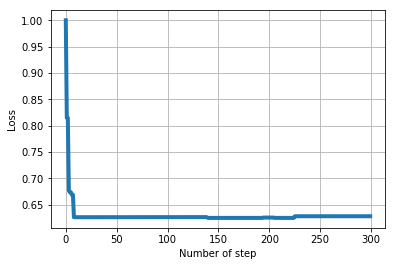

In [31]:
plt.plot(cost_history_SDCA, lw=4)
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

<a id='section7'></a>

# Comparaison des algorithmes

Comparons tous ces algorithmes sous deux critères : 
- le nombre d'itérations nécessaire
- le temps nécessaire

Il est important de comparer nos algorithmes sous ces deux angles car le temps d'exécution d'un algorithme est fonction des performances d'une machine donnée. En effet, les résultats sont biaisés par les différentes optimisations de la machine et ces optimisations n'ont pas de lien avec l'algorithme en lui-même.

A l'inverse, le nombre d'itérations est une mesure objective de la performance d'un algorithme, qui ne variera pas d'une machine à une autre, ni d'une implémentation à une autre. Son inconvénient est que certaines itérations d'algorithmes sont très longue (batch gradient descent) par rapport à d'autres (coordinate descent). Il est donc aussi difficile de comparer objectivement chaque algorithme.

Les graphiques produit ci-dessous permettent néanmoins de se faire une idée (grossière) de la réalité :

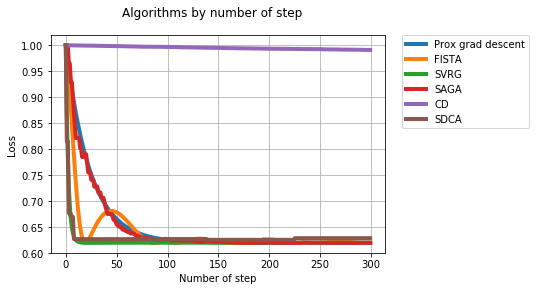

In [32]:
plt.plot(cost_history_PGD, lw=4, label='Prox grad descent')
plt.plot(cost_history_FISTA, lw=4, label='FISTA')
plt.plot(cost_history_SVRG, lw=4, label='SVRG')
plt.plot(cost_history_SAGA, lw=4, label='SAGA')
plt.plot(cost_history_CD, lw=4, label='CD')
plt.plot(cost_history_SDCA, lw=4, label='SDCA')

plt.grid()
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle('Algorithms by number of step')
plt.show()

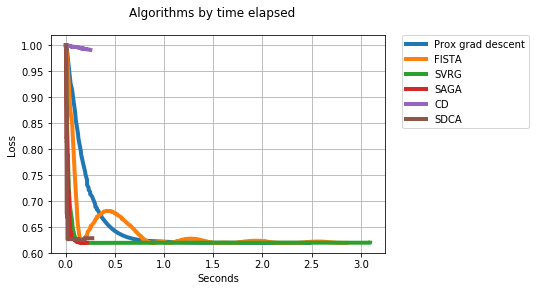

In [37]:
plt.plot(time_history_PGD[:,0], time_history_PGD[:,1], lw=4, label='Prox grad descent')
plt.plot(time_history_FISTA[:,0], time_history_FISTA[:,1], lw=4, label='FISTA')
plt.plot(time_history_SVRG[:,0], time_history_SVRG[:,1], lw=4, label='SVRG')
plt.plot(time_history_SAGA[:,0], time_history_SAGA[:,1], lw=4, label='SAGA')
plt.plot(time_history_CD[:,0], time_history_CD[:,1], lw=4, label='CD')
plt.plot(time_history_SDCA[:,0], time_history_SDCA[:,1], lw=4, label='SDCA')

plt.grid()
plt.ylabel('Loss')
plt.xlabel('Seconds')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle('Algorithms by time elapsed')
plt.show()

Enfin, voici un récapitulatif des performances des algorithmes dans les quatres conditions considérées (ce sont les images des graphiques précédents enregistrés à l'avance).

Commençons avec la comparaison en fonction du nombre d'itérations.

<table width="900" border="1" cellpadding="5">

<tr>

<td align="center" valign="center">
<img src="resultats/step_petit_petit.png" alt="peu de samples et features" />
<br />
peu de samples et features
</td>

<td align="center" valign="center">
<img src="resultats/step_grand_petit.png" alt="beaucoup de samples, peu de features" />
<br />
beaucoup de samples, peu de features
</td>

<td align="center" valign="center">
<img src="resultats/step_petit_grand.png" alt="peu de samples, beaucoup de features" />
<br />
peu de samples, beaucoup de features
</td>

<td align="center" valign="center">
<img src="resultats/step_grand_grand.png" alt="beaucoup de samples, beaucoup de features" />
<br />
beaucoup de samples, beaucoup de features
</td>

</tr>

</table>

Puis la même comparaison mais cette fois en fonction du temps écoulé (en secondes)

<table width="900" border="1" cellpadding="5">

<tr>

<td align="center" valign="center">
<img src="resultats/time_petit_petit.png" alt="peu de samples et features" />
<br />
peu de samples et features
</td>

<td align="center" valign="center">
<img src="resultats/time_grand_petit.png" alt="beaucoup de samples, peu de features" />
<br />
beaucoup de samples, peu de features
</td>

<td align="center" valign="center">
<img src="resultats/time_petit_grand.png" alt="peu de samples, beaucoup de features" />
<br />
peu de samples, beaucoup de features
</td>

<td align="center" valign="center">
<img src="resultats/time_grand_grand.png" alt="beaucoup de samples, beaucoup de features" />
<br />
beaucoup de samples, beaucoup de features
</td>

</tr>

</table>

Quelques remarques :
- SDCA semble être très performant lorsque le nombre de paramètres est très grand comparativement au nombre d'exemples. C'est cohérent avec l'algorithme : il optimise non pas sur l'espace des paramètres mais sur l'espace des individus.
- A l'inverse c'est le pire dans le cas contraire.

Concentrons-nous sur la comparaison par nombre d'itérations. C'est globalement un algorithme qui nécéssite plus d'itérations que les autres (mis à part le 3ème cas). En effet, l'algorithme favorise un nombre important d'itérations, chacunes rapides à calculer, à l'inverse de SVRG ou de FISTA qui préférent affecter plus de ressources à chaque pas afin d'espérer en faire moins in fine.

A propos du temps de calcul, SDCA est globalement mauvais comparativement aux autres lorsque le problème à résoudre est simple, et semble être de plus en intéressant lorsque le problème se complexifie. On ne fera pas d'autres commentaires sur ces mesures car elles sont trop dépendantes des optimisations d'implémentations possibles.

Enfin, et pour conclure, comparons SDCA à sa version conjuguée, le Coordinate Descent. Comme on pouvait s'y attendre, CD est meilleur dans le cas où la dimension du paramètre est petite, et inversement. 